In [1]:
#!pip install nltk
#!pip install emoji
#!pip install Arabic-Stopwords
#!pip install PyArabic
#!pip install Tashaphyne
#!pip install translate
#!pip install transformers

In [2]:
#importing libaraires

# Add environment Packages paths to conda
import os, sys, warnings
import pandas as pd
import numpy as np
warnings.simplefilter("ignore")

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
import regex
import emoji
# Corpora is a group presenting multiple collections of text documents. A single collection is called corpus.
from nltk.corpus import stopwords # Stopwords
nltk.download('stopwords')
import arabicstopwords.arabicstopwords as stp #more range of arabic stop words
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from tashaphyne.stemming import ArabicLightStemmer

from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
#from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC
# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khalifa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df=pd.read_csv('arabic-empathetic-conversations.csv')
df.head()

,emotion,context,response
0,sentimental,أتذكر أنني ذهبت لمشاهدة الألعاب النارية مع أعز...,هل كان هذا صديقًا كنت تحبه أم مجرد أفضل صديق؟
1,sentimental,كان هذا أفضل صديق. اشتقت لها.,اين ذهبت؟
2,sentimental,لم نعد نتحدث.,هل كان هذا شيء حدث بسبب جدال؟
3,afraid,أشعر وكأنني ضرب على جدار فارغ عندما أرى الظلام,أجل؟ أنا حقا لا أرى كيف
4,afraid,ألا تشعر بذلك .. إنه لأمر عجيب,أصطدم في الواقع بجدران فارغة في كثير من الأحيا...


In [4]:
#deop unnecessary columns
df.drop('response', axis=1,inplace=True)
df.rename(columns={'emotion':'label', 'context':'text'}, inplace = True)

## Assessing

In [5]:
#print the shape of the data set
df.shape

(36628, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36628 entries, 0 to 36627
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   36628 non-null  object
 1   text    36628 non-null  object
dtypes: object(2)
memory usage: 572.4+ KB


In [7]:
#check if the data is balanced or not
df.label.value_counts()

surprised       1886
excited         1404
angry           1310
proud           1301
annoyed         1259
sad             1258
afraid          1201
lonely          1197
grateful        1196
terrified       1186
guilty          1172
confident       1170
anxious         1170
disgusted       1164
anticipating    1163
hopeful         1155
furious         1148
impressed       1144
joyful          1132
disappointed    1123
nostalgic       1120
jealous         1115
prepared        1097
content         1063
devastated      1053
embarrassed     1042
sentimental      984
caring           977
trusting         954
ashamed          938
apprehensive     870
faithful         676
Name: label, dtype: int64

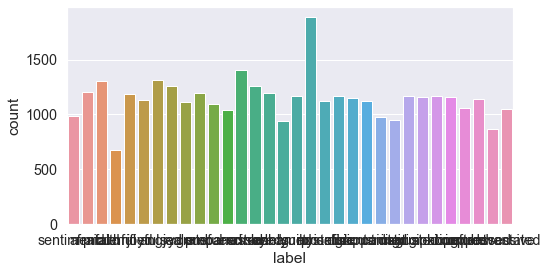

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df);

The differences between the labels is not large so, we can say that the data is balanced

In [9]:
#print the number of null values in each column
df.isnull().sum()

label    0
text     0
dtype: int64

In [10]:
#to get the index of the null value
df[df['text'].isnull() == True]

,label,text


This label doesn't mean anything because the original text is missing so, we will remove it

In [11]:
#print the number of duplicated values 
df.duplicated().sum()

325

In [12]:
#print the rows which are duplicated
df[df['text'].duplicated() == True]

,label,text
588,terrified,عندما كنت أصغر سنًا ، كان والدي يخافني ويخاف إ...
996,jealous,أريد أن أكون غنيًا وطويل القامة مثل ليبرون.
1376,anticipating,لا استطيع الانتظار ليوم الاحد المقبل
1930,joyful,نعم
2364,proud,hi
...,...,...
36322,grateful,إنه يعمل بجد من أجل عائلتنا حتى أتمكن من البقا...
36349,sentimental,أعطاني جدي ساعة جيبه
36423,jealous,أشعر بالغيرة من زميلي في العمل ، فهو ذكي للغاي...
36577,faithful,الإرشاد المدرسي.


In [13]:
df[df['text'] == df.iloc[1236]['text']]

,label,text
1236,afraid,اتضح أنه كان غزالًا عالق في الأدغال.


In [14]:
#removing duplicated values
index = df[df['text'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)

In [15]:
#are there any stop words in the data?
arabic_stopwords = stopwords.words("arabic")
len(arabic_stopwords)

754

Note that There are different libraries provide a different numbers of arabic stop words like "nltk" and "arabicstopwords" now we will use nltk's arabic stopwords and we will see the results and if needed we can use "arabicstopwords" library which provide the stopwords and it's conjugations

In [16]:
df['stop_words'] = df['text'].apply(lambda x: len(set(x.split()) & set(arabic_stopwords)))
df.stop_words.value_counts()

2     7751
3     6675
1     6576
4     4613
5     3029
0     2939
6     1882
7     1137
8      608
9      375
10     203
11     137
12      64
13      36
14      25
15      16
16      16
17       3
20       3
18       2
19       1
21       1
23       1
Name: stop_words, dtype: int64

<AxesSubplot:ylabel='Frequency'>

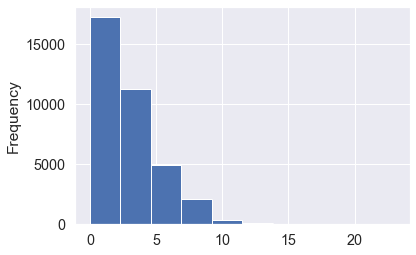

In [17]:
df['stop_words'].plot(kind= 'hist')

it seems that the data contains alot of stop words and it should be removed

### Assessing Results

- The data contains null values
- The data contains duplicated values
- The data is balanced and contains 8 classes
- About 20% of the data contains emojis
- More than 85% of the text in each records contains stopwords
- the data contains Diacritics 
- The data contains Punctuations, Disapprobation words and hashtags and other things that we should take care during cleaning and preprocessing

## Cleaning

### Functions

In [18]:
def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in arabic_stopwords]
    return " ".join(Text)

def ISRI_Stemmer(text):
    #making an object
    stemmer = ISRIStemmer()
    
    #stemming each word
    text = stemmer.stem(text)
    text = stemmer.pre32(text)
    text = stemmer.suf32(text)
    
    return text

def Snowball_stemmer(text):
    text = text.split()
    #making an object
    stemmer = SnowballStemmer("arabic")
    
    #stemming each word
    text=[stemmer.stem(y) for y in text]
    
    return " " .join(text)

def Arabic_Light_Stemmer(text):
    #making an object
    Arabic_Stemmer = ArabicLightStemmer()
    
    #stemming each word
    text=[Arabic_Stemmer.light_stem(y) for y in text.split()]
    
    return " " .join(text)

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    
    #remove repetetions
    text = re.sub("[إأٱآا]", "ا", text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('ييي', 'ي')
    text = text.replace('اا', 'ا')

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # Remove longation
    text = re.sub(r'(.)\1+', r"\1\1", text) 
    
    #Strip vowels from a text, include Shadda.
    text = araby.strip_tashkeel(text)
    
    #Strip diacritics from a text, include harakats and small lettres The striped marks are
    text = araby.strip_diacritics(text)
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_non_arabic(text):
    text = re.sub('[A-Za-z]+',' ',text)
    return text

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_extra_Space(text):
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    return text

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            

In [19]:
cleaned_data=pd.read_csv('arabic-empathetic-conversations.csv')
df.head()

,label,text,stop_words
0,sentimental,أتذكر أنني ذهبت لمشاهدة الألعاب النارية مع أعز...,9
1,sentimental,كان هذا أفضل صديق. اشتقت لها.,2
2,sentimental,لم نعد نتحدث.,1
3,afraid,أشعر وكأنني ضرب على جدار فارغ عندما أرى الظلام,2
4,afraid,ألا تشعر بذلك .. إنه لأمر عجيب,2


**drop unnecessary columns**

In [20]:
#deop unnecessary columns
cleaned_data.drop('response', axis=1,inplace=True)
cleaned_data.rename(columns={'emotion':'label', 'context':'text'}, inplace = True)

**removing null values**

In [21]:
#Before
df.isnull().sum()

label         0
text          0
stop_words    0
dtype: int64

In [22]:
#Ater
cleaned_data.isnull().sum()

label    0
text     0
dtype: int64

**removing duplicated values**

In [23]:
index = cleaned_data[cleaned_data['text'].duplicated() == True].index
cleaned_data.drop(index, axis = 0, inplace = True)

#resetting the index of the data
cleaned_data.reset_index(drop=True, inplace = True)

In [24]:
#Before
df.duplicated().sum()

0

In [25]:
#Ater
cleaned_data.duplicated().sum()

0

**removing arabic stopwords**

In [26]:
cleaned_data.text=cleaned_data.text.apply(lambda text : remove_stop_words(text))

In [27]:
#Before
df.text[2]

'لم نعد نتحدث.'

In [28]:
#After
cleaned_data.text[1]

'أفضل صديق. اشتقت لها.'

**Removal of non-Arabic words**

In [29]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_non_arabic(text))

In [30]:
#Before
df.text.iloc[10016]

'أعلم أنني سأفوز بالميدالية الذهبية في الأولمبياد.'

In [31]:
#After
cleaned_data.iloc[10016].text

'أنني سأفوز بالميدالية الذهبية الأولمبياد.'

**removing Diacritics**

In [32]:
cleaned_data.text=cleaned_data.text.apply(lambda text : normalizeArabic(text))

In [33]:
df.text.iloc[99]

'لن تصدق أبدًا ما فعلته'

In [34]:
cleaned_data.text.iloc[99]

'تصدق ابدا فعلته'

**Removal of numbers**

In [35]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_numbers(text))

In [36]:
#Before
df.text.iloc[10015]

'نعم ، إنه كريم جدا.'

In [37]:
cleaned_data.iloc[10015].text

'، كريم جدا.'

In [38]:
cleaned_data.iloc[12].text

'مرحبا ، العام ، كنت  طالب كليه الهندسه'

**Removing Hastags**

In [39]:
for i in range(len(cleaned_data)):
    index = cleaned_data.text.iloc[i].find("#")
    if index != -1:
        print(index)

90
47
70
20


In [40]:
cleaned_data.iloc[90].text

'قررت وزوجتي الذهاب رحله دوليه العام الماضي ، وكانت رحله خارج الولايات المتحده. لقد كانت تجربه راءعه ، وكانت واحده افضل واشهر الاشياء قمت الاطلاق.'

it seems that the data doesn't contains hastgas

**Removal of Links**

In [41]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_urls(text))

**Removing Punctuations**

In [42]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Removing_punctuations(text))

In [43]:
#Before
df.text.iloc[0]

'أتذكر أنني ذهبت لمشاهدة الألعاب النارية مع أعز أصدقائي. كانت هذه هي المرة الأولى التي قضينا فيها وقتًا بمفردنا معًا. على الرغم من وجود الكثير من الأشخاص ، إلا أننا شعرنا بأننا الأشخاص الوحيدون في العالم.'

In [44]:
#After
cleaned_data.text.iloc[0]

'اتذكر انني ذهبت لمشاهده الالعاب الناريه اعز اصدقاءي كانت المره الاولي قضينا وقتا بمفردنا معا الرغم وجود الكثير الاشخاص اننا شعرنا باننا الاشخاص الوحيدون العالم'

**Reducing words to their roots**

In [45]:
cleaned_data.text=cleaned_data.text.apply(lambda text : Arabic_Light_Stemmer(text))

In [46]:
cleaned_data.duplicated().sum()

345

Note that: duplicated value was found when we remove diacritics and non arabic words and punctuations and this because some rows in the dataset only contains stopwords or it contains one or two words and other reasons so, we have to remove the duplicated values again

In [47]:
index = cleaned_data[cleaned_data['text'].duplicated() == True].index
cleaned_data.drop(index, axis = 0, inplace = True)

#resetting the index of the data
cleaned_data.reset_index(drop=True, inplace = True)

In [48]:
cleaned_data.duplicated().sum()

0

After removing the duplicated values we will remove every row which contains only one or two words berfore preprocessing

In [49]:
#this function will convert the text which contains one or two words into null value
remove_small_sentences(cleaned_data)

In [50]:
cleaned_data.isnull().sum()

label       0
text     1130
dtype: int64

In [51]:
cleaned_data.dropna(inplace = True)

In [52]:
cleaned_data

,label,text
0,sentimental,تذكر نن ذهب مشاهد العاب ناريه عز اصدقاء انت مر...
1,sentimental,فضل صديق اشتق لها
3,afraid,شعر انن ضرب جدار رغ عندم ظلام
4,afraid,شعر ذلك امر عجيب
5,afraid,اعتقد عملي نت تعرق
...,...,...
35527,afraid,حترق منزل ليله سابقه اضطرر خراج مي
35528,sentimental,نت تصفح اشياء عليه ليله ماضيه
35529,sentimental,جد صور قديمه عندم عتد اطفال ذهاب منزل جد عيد م...
35530,surprised,استيقظ صباح زوج خبر نه حامل


Remove Emoji

In [53]:
cleaned_data.drop(18210, axis=0, inplace = True)

Label Data to Six Label.

In [54]:
cleaned_data.loc[cleaned_data.label =="angry", "label"]="Anger"
cleaned_data.loc[cleaned_data.label =="annoyed", "label"]="Anger"
cleaned_data.loc[cleaned_data.label =="furious", "label"]="Anger"
cleaned_data.loc[cleaned_data.label =="jealous", "label"]="Anger"
cleaned_data.loc[cleaned_data.label =="disgusted", "label"]="Anger"

cleaned_data.loc[cleaned_data.label =="sad", "label"]="Sadness"
cleaned_data.loc[cleaned_data.label =="lonely", "label"]="Sadness"
cleaned_data.loc[cleaned_data.label =="guilty", "label"]="Sadness"
cleaned_data.loc[cleaned_data.label =="disappointed", "label"]="Sadness"
cleaned_data.loc[cleaned_data.label =="devastated", "label"]="Sadness"
cleaned_data.loc[cleaned_data.label =="embarrassed", "label"]="Sadness"
cleaned_data.loc[cleaned_data.label =="ashamed", "label"]="Sadness"

cleaned_data.loc[cleaned_data.label =="surprised", "label"]="Surprise"
cleaned_data.loc[cleaned_data.label =="impressed", "label"]="Surprise"


cleaned_data.loc[cleaned_data.label =="caring", "label"]="Love"
cleaned_data.loc[cleaned_data.label =="sentimental", "label"]="Love"
cleaned_data.loc[cleaned_data.label =="trusting", "label"]="Love"
cleaned_data.loc[cleaned_data.label =="faithful", "label"]="Love"
cleaned_data.loc[cleaned_data.label =="nostalgic", "label"]="Love"

cleaned_data.loc[cleaned_data.label =="excited", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="proud", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="grateful", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="confident", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="hopeful", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="anticipating", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="prepared", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="content", "label"]="joy"
cleaned_data.loc[cleaned_data.label =="joyful", "label"]="joy"

cleaned_data.loc[cleaned_data.label =="afraid", "label"]="fear"
cleaned_data.loc[cleaned_data.label =="terrified", "label"]="fear"
cleaned_data.loc[cleaned_data.label =="anxious", "label"]="fear"
cleaned_data.loc[cleaned_data.label =="apprehensive", "label"]="fear"

In [55]:
cleaned_data.to_csv('arabic-empathetic-conversations_ISRI_stemmer_without.csv', index = False, encoding='utf-8-sig')

## Modeling

In [56]:
X = cleaned_data.text.values
y = cleaned_data.label.values

In [57]:
print(X[:5])

['تذكر نن ذهب مشاهد العاب ناريه عز اصدقاء انت مره اول قض قت مفرد مع رغم جود كثير اشخاص نن شعر ان اشخاص وحيد عالم'
 'فضل صديق اشتق لها' 'شعر انن ضرب جدار رغ عندم ظلام' 'شعر ذلك امر عجيب'
 'اعتقد عملي نت تعرق']


In [58]:
print(y[:5])

['Love' 'Love' 'fear' 'fear' 'fear']


**Creating a pipline using tf-idf for words embedding and different models.**

In [59]:
def train_model(model, data, targets):
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    text_clf.fit(data, targets)
    return text_clf

In [60]:
def get_F1(trained_model,X,y):
    predicted=trained_model.predict(X)
    f1=f1_score(y,predicted, average=None)
    return f1

**Splitting the dataset into the Training set and Test set**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True, random_state=42)

### Logistic Regression

**Training the Logistic Regression model on the Training set**

In [62]:
log_reg = train_model(LogisticRegression(random_state = 0), X_train, y_train)

**Predicting new data**

In [63]:
y_pred=log_reg.predict(['سعيد'])
y_pred

array(['joy'], dtype=object)

In [64]:
y_pred=log_reg.predict(['حزن'])
y_pred

array(['Sadness'], dtype=object)

In [65]:
y_pred=log_reg.predict(['مستغرب'])
y_pred

array(['joy'], dtype=object)

**Predicting the Test set results**

**Measuring the performance**

In [66]:
y_pred=log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

Accuracy:  0.5544252288911495 



In [67]:
y_pred=log_reg.predict(X_train)
print(y_pred.shape)
log_reg_accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

(27520,)
Accuracy:  0.6731468023255814 



In [68]:
##Classification Report
print(classification_report(y_test,y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [6881, 27520]

### Decision Tree

**Training the Decision Tree model on the Training set**

In [ ]:
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

**Predicting the Test set results**

In [ ]:
y_pred=DT.predict(X_test)
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

In [ ]:
y_pred=DT.predict(X_train)
DT_accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

In [ ]:
f1_Score = get_F1(DT, X_test ,y_test)
pd.DataFrame(f1_Score, index=df.label.unique(), columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

### Support Vector Machine

**Training the Support Vector Machine model on the Training set**

In [ ]:
SVM = train_model(SVC(random_state = 0), X_train, y_train)

**Predicting the Test set results**

In [ ]:
y_pred=SVM.predict(X_test)
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

In [ ]:
y_pred=SVM.predict(X_train)
SVM_accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

In [ ]:
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df.label.unique(), columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

### Random Forest

**Training the Random Forest model on the Training set**

In [ ]:
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

**Predicting the Test set results**

In [ ]:
y_pred=RF.predict(X_test)

**Measuring the performance**

In [ ]:
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

In [ ]:
y_pred=RF.predict(X_train)
RF_accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

In [ ]:
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df.label.unique(), columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)